In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, auc, roc_curve,accuracy_score, precision_score, recall_score, multilabel_confusion_matrix
from torch import tensor
import torch
#import matplotlib
import torch.nn.functional as F
import math
#matplotlib.use('Agg')

#import matplotlib.pyplot as plt

In [2]:
a = torch.tensor([1.,2.,3.])
b = F.softmax(a)
c = F.log_softmax(a)
print(b)
print(c)
d = torch.exp(c)
print(d)

C:\Users\Haiyang Jiang\AppData\Local\Temp\ipykernel_20028\3385081874.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  b = F.softmax(a)
C:\Users\Haiyang Jiang\AppData\Local\Temp\ipykernel_20028\3385081874.py:3: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.log_softmax(a)


tensor([0.0900, 0.2447, 0.6652])
tensor([-2.4076, -1.4076, -0.4076])
tensor([0.0900, 0.2447, 0.6652])


In [3]:
def get_y_true_pred1(O123):
    Y_true = []
    Y_pred1 = []
    Labels = []
    for i in range(O123.shape[1]):
        if i%3==0:
            y_true = O123[:,i]
            y_pred = O123[:,i+1:i+3]
            pred = np.argmax(y_pred,axis=1)#[1]
            Labels.append(np.stack([y_true,pred],axis=1))
            y_pred0 = O123[:,i+1]
            y_pred1 = O123[:,i+2]
        else:
            continue
        Y_true.append(y_true)
        Y_pred1.append(y_pred1)
    
    return np.concatenate(Y_true), np.concatenate(Y_pred1), Labels

In [4]:
O123 = np.loadtxt(open('GCN_Net123.csv',"rb"), delimiter=",", skiprows=0)
O1 = np.loadtxt(open('GCN_Net1.csv',"rb"), delimiter=",", skiprows=0)
O2 = np.loadtxt(open('GCN_Net2.csv',"rb"), delimiter=",", skiprows=0)
O3 = np.loadtxt(open('GCN_Net3.csv',"rb"), delimiter=",", skiprows=0)

Y123_true, Y123_pred1, Labels123 = get_y_true_pred1(O123)
Y1_true, Y1_pred1, Labels1 = get_y_true_pred1(O1)
Y2_true, Y2_pred1, Labels2 = get_y_true_pred1(O2)
Y3_true, Y3_pred1, Labels3 = get_y_true_pred1(O3)

In [5]:
LL = np.concatenate(Labels3,axis=1)
np.savetxt('GCN_Net3test.csv',LL,fmt='%f',delimiter=",")


In [6]:
#Y_true = np.concatenate(Y_true)
#Y_pred1 = np.concatenate(Y_pred1)

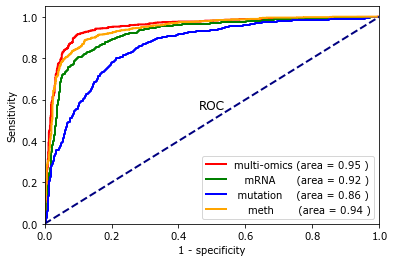

In [7]:
fpr123, tpr123, threshold123 = roc_curve(Y123_true, Y123_pred1)
roc_auc123 = auc(fpr123,tpr123)
fpr1, tpr1, threshold1 = roc_curve(Y1_true, Y1_pred1)
roc_auc1 = auc(fpr1,tpr1)
fpr2, tpr2, threshold2 = roc_curve(Y2_true, Y2_pred1)
roc_auc2 = auc(fpr2,tpr2)
fpr3, tpr3, threshold3 = roc_curve(Y3_true, Y3_pred1)
roc_auc3 = auc(fpr3,tpr3)
plt.plot(fpr123, tpr123, color='red',
         lw=2, label='multi-omics (area = {:.2f} )'.format(roc_auc123))  # 假正率为横坐标，真正率为纵坐标做曲线
plt.plot(fpr1, tpr1, color='green',
         lw=2, label='   mRNA      (area = {:.2f} )'.format(roc_auc1))
plt.plot(fpr2, tpr2, color='blue',
         lw=2, label=' mutation    (area = {:.2f} )'.format(roc_auc2))
plt.plot(fpr3, tpr3, color='orange',
         lw=2, label='    meth       (area = {:.2f} )'.format(roc_auc3))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.0, 1.0])
plt.ylim([-0.0, 1.05])
plt.xlabel('1 - specificity')
plt.ylabel('Sensitivity')
plt.title('ROC', y=0.5)
plt.legend(loc="lower right")
plt.show()

In [8]:
y = Y_true.reshape(75,-1)

NameError: name 'Y_true' is not defined

In [ ]:
y

In [9]:

def specificityCalc(Labels, Predictions):
    MCM = multilabel_confusion_matrix(Labels, Predictions,
                                      sample_weight=None,
                                      labels=None, samplewise=None)
    tn_sum = MCM[:, 0, 0]
    fp_sum = MCM[:, 0, 1]

    tp_sum = MCM[:, 1, 1]
    fn_sum = MCM[:, 1, 0]

    Condition_negative = tn_sum + fp_sum + 1e-6

    Specificity = tn_sum / Condition_negative
    macro_specificity = np.average(Specificity, weights=None)

    micro_specificity = np.sum(tn_sum) / np.sum(tn_sum+fp_sum)

    return macro_specificity, micro_specificity

In [10]:
O123 = np.loadtxt(open('GCN_Net123test.csv',"rb"), delimiter=",", skiprows=0)#[1:,:]
O1 = np.loadtxt(open('GCN_Net1test.csv',"rb"), delimiter=",", skiprows=0)
O2 = np.loadtxt(open('GCN_Net2test.csv',"rb"), delimiter=",", skiprows=0)#[1:,:]
O3 = np.loadtxt(open('GCN_Net3test.csv',"rb"), delimiter=",", skiprows=0)
O_list = [O1, O2, O3, O123]

In [11]:
#O1_acc, O2_acc, O3_acc, O123_acc = [], [], [], []
Recall = []
Precision = []
F1 = []
Specificity  = []
Acc = []
#O1_f1, O2_f1, O3_f1, O123_f1 = [], [], [], []


In [12]:
for i in range(len(O_list)):
    recall = []
    precision = []
    f1 = []
    specificity  = []
    acc = []
    O_data = O_list[i]
    for j in range(O_data.shape[1]):
        if j%2==0:
            y_true = O_data[:,j]
            y_pred = O_data[:,j+1]
        if j%2==1:
            continue
        recall.append(recall_score(y_true, y_pred))
        precision.append(precision_score(y_true, y_pred))
        f1.append(f1_score(y_true, y_pred))
        specificity.append(specificityCalc(y_true, y_pred)[1])
        acc.append(accuracy_score(y_true, y_pred)) 
    recall_array = np.array(recall)
    precision_array = np.array(precision)
    f1_array = np.array(f1)
    specificity_array = np.array(specificity)
    acc_array = np.array(acc)
    
    Recall.append(recall_array)
    Precision.append(precision_array)
    F1.append(f1_array)
    Specificity.append(specificity_array)
    Acc.append(acc_array)
 

In [13]:


Recall_array = np.array(Recall)
Precision_array = np.array(Precision)
F1_array = np.array(F1)  #O1_f1, O2_f1, O3_f1, O123_f1
Specificity_array = np.array(Specificity)
Acc_array = np.array(Acc)  #O1_acc, O2_acc, O3_acc, O123_acc


In [14]:
np.savetxt('GCN_Recall.csv',Recall_array,fmt='%f',delimiter=",")
np.savetxt('GCN_Precision.csv',Precision_array,fmt='%f',delimiter=",")
np.savetxt('GCN_F1.csv',F1_array,fmt='%f',delimiter=",")
np.savetxt('GCN_Specificity.csv',Specificity_array,fmt='%f',delimiter=",")
np.savetxt('GCN_Acc.csv',Acc_array,fmt='%f',delimiter=",")


In [18]:
Recall_mean = []
Recall_std = []
Precision_mean = []
Precision_std = []
F1_mean = []
F1_std = []
Specificity_mean = []
Specificity_std = []
Acc_mean = []
Acc_std = []
#F1_tensor = tensor(F1_array)
#Acc_tensor = tensor(Acc_array)
for i in range(F1_array.shape[0]):
    
    Recall_mean.append(np.mean(Recall_array[i]))
    Recall_std.append(np.std(Recall_array[i]))
    Precision_mean.append(np.mean(Precision_array[i]))
    Precision_std.append(np.std(Precision_array[i]))
    F1_mean.append(np.mean(F1_array[i]))
    F1_std.append(np.std(F1_array[i]))
    Specificity_mean.append(np.mean(Specificity_array[i]))
    Specificity_std.append(np.std(Specificity_array[i]))
    Acc_mean.append(np.mean(Acc_array[i]))
    Acc_std.append(np.std(Acc_array[i]))
    

In [21]:
print('Recall: {:.2f} ± {:.2f}'.format(Recall_mean[-1]*100,Recall_std[-1]*100 ))
print('Precision: {:.2f} ± {:.2f}'.format(Precision_mean[-1]*100,Precision_std[-1]*100 ))
print('F1: {:.2f} ± {:.2f}'.format(F1_mean[-1]*100,F1_std[-1]*100 ))
print('Specificity: {:.2f} ± {:.2f}'.format(Specificity_mean[-1]*100,Specificity_std[-1]*100 ))
print('Acc: {:.2f} ± {:.2f}'.format(Acc_mean[-1]*100,Acc_std[-1]*100 ))


print(Recall_mean[-1],Recall_std[-1])
print(Precision_mean[-1], Precision_std[-1])
print(F1_mean[-1], F1_std[-1])
print(Specificity_mean[-1], Specificity_std[-1])
print(Acc_mean[-1], Acc_std[-1])
print()

Recall: 89.93 ± 5.04
Precision: 91.51 ± 5.27
F1: 90.53 ± 3.24
Specificity: 90.56 ± 3.35
Acc: 90.56 ± 3.35
0.8992603129445235 0.0503644100305489
0.9150985265321089 0.0527187076881243
0.9052522762190217 0.03244388862221435
0.9056000000000001 0.03350250405235074
0.9056000000000001 0.03350250405235074



In [10]:
F1_mean

[0.8640251495596384,
 0.7785599325042188,
 0.8854790600253958,
 0.8991904658714833]

In [16]:
FPR = [0,1]
TPR = [0,1]
ROC_AUC = []
for i in range(O123.shape[1]):
    if i%2==0:
        #print("i",i)
        y_true = O123[:,i]
        y_pred = O123[:,i+1]
        
    if i%2==1:
        continue
    
    fpr, tpr, threshold = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr,tpr)
    ROC_AUC.append(roc_auc)
    FPR.append(fpr[1])
    TPR.append(tpr[1])

In [17]:
FPR


[0,
 1,
 0.13157894736842105,
 0.07894736842105263,
 0.07894736842105263,
 0.13157894736842105,
 0.10526315789473684,
 0.18421052631578946,
 0.10526315789473684,
 0.07894736842105263,
 0.21052631578947367,
 0.05263157894736842,
 0.13513513513513514,
 0.10810810810810811,
 0.02702702702702703,
 0.02702702702702703,
 0.08108108108108109,
 0.02702702702702703,
 0.0,
 0.02702702702702703,
 0.02702702702702703,
 0.05405405405405406,
 0.08108108108108109,
 0.10810810810810811,
 0.08108108108108109,
 0.10810810810810811,
 0.10810810810810811]

In [18]:
TPR

[0,
 1,
 0.8648648648648649,
 0.918918918918919,
 0.9459459459459459,
 0.9459459459459459,
 0.918918918918919,
 0.8648648648648649,
 0.8918918918918919,
 0.918918918918919,
 0.8648648648648649,
 0.918918918918919,
 0.7894736842105263,
 0.868421052631579,
 0.7894736842105263,
 0.8421052631578947,
 0.868421052631579,
 0.8947368421052632,
 0.868421052631579,
 0.8947368421052632,
 0.8947368421052632,
 0.8947368421052632,
 0.8421052631578947,
 0.9736842105263158,
 0.868421052631579,
 0.9210526315789473,
 0.9210526315789473]

(-0.0, 1.0)

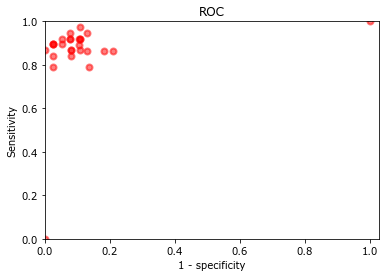

In [24]:
# 2.创建一张figure
fig = plt.figure(1)
# 3. 设置颜色 color 值【可选参数，即可填可不填】，方式有几种
# colors = np.random.rand(n) # 随机产生10个0~1之间的颜色值，或者
colors = ['r', 'g', 'y', 'b', 'r', 'c', 'g', 'b', 'k', 'm']  # 可设置随机数取
# 4. 设置点的面积大小 area 值 【可选参数】
#area = 20*np.arange(1, n+1)
# 5. 设置点的边界线宽度 【可选参数】
# 6. 正式绘制散点图：scatter
plt.scatter(FPR, TPR, c='r', linewidths=2, alpha=0.5, marker='o')
# 7. 设置轴标签：xlabel、ylabel
#设置X轴标签
plt.xlabel('1 - specificity')
#设置Y轴标签
plt.ylabel('Sensitivity')
# 8. 设置图标题：title
plt.title('ROC')
# 9. 设置轴的上下限显示值：xlim、ylim
# 设置横轴的上下限值
plt.xlim(-0.0, 1.03)
# 设置纵轴的上下限值
plt.ylim(-0.0, 1)

In [36]:
labels = [1,0,0,1,0,1,1,0,1,0]
#preds = [1,1,0,1,0,1,0,0,1,1,1]
#preds = np.array([0.28,0.2,0.73,0.98,0.33,0.95,0.87,0.35,0.77,0.21])
preds = np.array([[0.28,0.72], [0.2,0.8], [0.73,0.27], [0.98,0.02], [0.33,0.67],
                  [0.95,0.05], [0.87,0.13], [0.35,0.65], [0.77,0.23], [0.21,0.79]])[:,0]
preds.shape

(10,)

<Figure size 432x288 with 0 Axes>

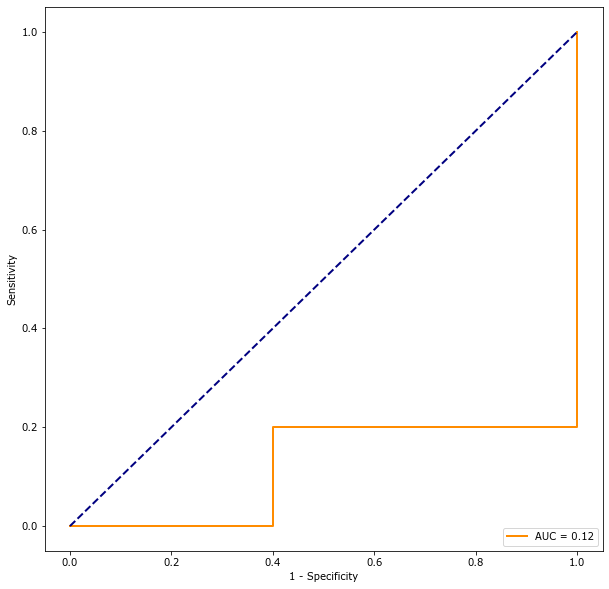

In [37]:

fpr1, tpr1, threshold1 = roc_curve(labels, preds)  ###计算真正率和假正率

roc_auc1 = auc(fpr1, tpr1)  ###计算auc的值，auc就是曲线包围的面积，越大越好
plt.figure()
lw = 2
plt.figure(figsize=(10, 10))
plt.plot(fpr1, tpr1, color='darkorange',
        lw=lw, label='AUC = %0.2f' % roc_auc1)  ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
# plt.title('ROCs for Densenet')
plt.legend(loc="lower right")
# plt.show()

In [72]:
O3

array([[0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 0., 1., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.]])